# CNN Model for Handwritten Digit Recognition - EMNIST Dataset

The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19  and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import numpy as np

In [2]:
# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 36)  # 36 classes (0-9, A-Z)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(-1, 64 * 5 * 5)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Mapping for EMNIST Balanced labels (filter out lowercase)
def map_emnist_labels(label):
    if label < 10:  # Digits 0–9
        return label
    elif 10 <= label < 36:  # Uppercase letters A-Z
        return label
    else:  # Exclude lowercase letters
        return None

# Custom Dataset with Filtering
class FilteredEMNISTDataset(datasets.EMNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data, self.targets = self._filter_invalid_labels()

    def _filter_invalid_labels(self):
        valid_indices = [i for i, label in enumerate(self.targets) if map_emnist_labels(label) is not None]
        mapped_targets = [map_emnist_labels(label) for i, label in enumerate(self.targets) if map_emnist_labels(label) is not None]
        return self.data[valid_indices], torch.tensor(mapped_targets)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]
        # No need to apply ToTensor since images are already in tensor form
        image = image.unsqueeze(0).float()  # Adding channel dimension (1 channel for grayscale) and converting to float
        return image, label

In [43]:
# Transform for EMNIST images
transform = transforms.Compose([
    transforms.Lambda(lambda img: F.hflip(img)),          # undo horizontal inversion
    transforms.Lambda(lambda img: F.rotate(img, 90)),    # rotate 90° CW
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load and filter dataset
emnist_data = FilteredEMNISTDataset(root='./data', split='balanced', train=True, download=True, transform=transform)

In [26]:
len(emnist_data)

86400

In [44]:
# Split into train and test sets
train_size = int(0.8 * len(emnist_data))
test_size = len(emnist_data) - train_size
train_data, test_data = random_split(emnist_data, [train_size, test_size])

# Data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Label map for visualization
labels_map = {i: chr(48 + i) if i < 10 else chr(65 + i - 10) for i in range(36)}  # 0-9 and A-Z

In [19]:
print(f"Number of classes: {len(emnist_data.classes)}")
print(f"Classes: {emnist_data.classes}")

Number of classes: 47
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [40]:
# Count the number of images per class
train_indices = train_data.indices
test_indices = test_data.indices

train_counts = Counter([emnist_data.targets[i].item() for i in train_indices])
test_counts = Counter([emnist_data.targets[i].item() for i in test_indices])

# Get the number of classes and labels
classes = list(labels_map.values())

print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

Number of classes: 36
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


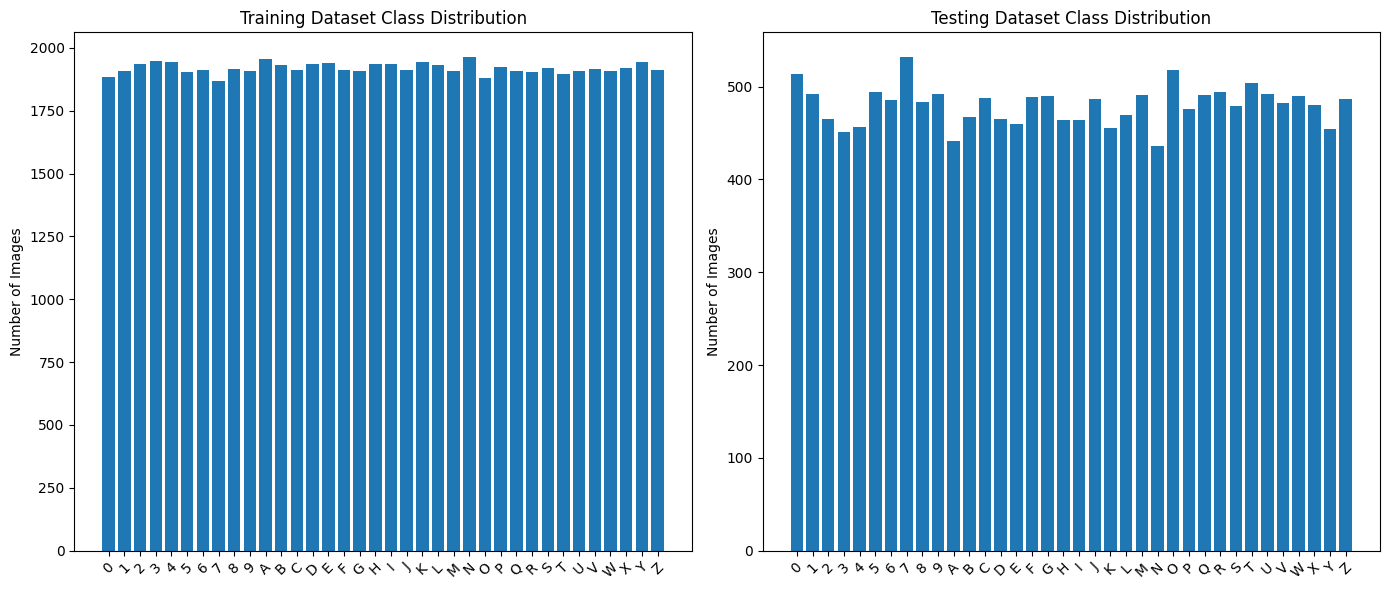

In [29]:
# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Training dataset distribution
ax[0].bar(classes, [train_counts.get(i, 0) for i in range(len(classes))])
ax[0].set_title("Training Dataset Class Distribution")
ax[0].set_xticks(range(len(classes)))
ax[0].set_xticklabels(classes, rotation=45)
ax[0].set_ylabel("Number of Images")

# Testing dataset distribution
ax[1].bar(classes, [test_counts.get(i, 0) for i in range(len(classes))])
ax[1].set_title("Testing Dataset Class Distribution")
ax[1].set_xticks(range(len(classes)))
ax[1].set_xticklabels(classes, rotation=45)
ax[1].set_ylabel("Number of Images")

plt.tight_layout()
plt.show()

In [35]:
# Visualize random images
def visualize_random_images(dataset, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2.5))
    for i in range(num_images):
        random_idx = torch.randint(0, len(dataset), size=(1,)).item()
        img, label = dataset[random_idx]
        img = img.squeeze()  # Remove channel dimension
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {labels_map[label.item()]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

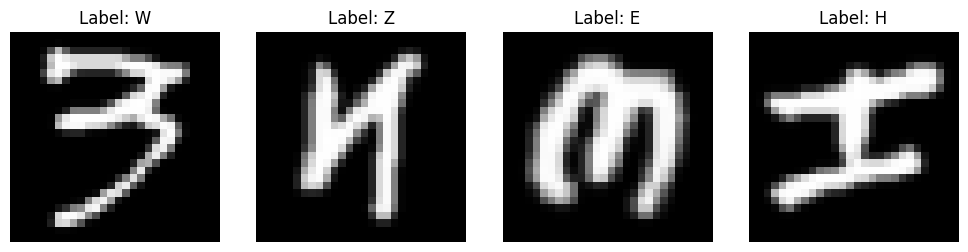

In [45]:
visualize_random_images(train_data)

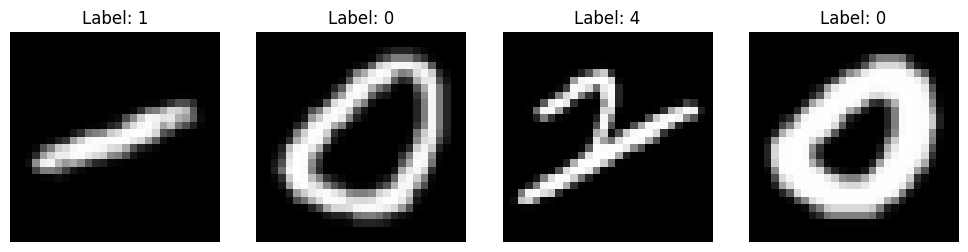

In [46]:
visualize_random_images(train_data)

In [47]:
# Initialize model, loss, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/15], Loss: 1.0827
Epoch [2/15], Loss: 0.4340
Epoch [3/15], Loss: 0.3434
Epoch [4/15], Loss: 0.2946
Epoch [5/15], Loss: 0.2608
Epoch [6/15], Loss: 0.2334
Epoch [7/15], Loss: 0.2127
Epoch [8/15], Loss: 0.1910
Epoch [9/15], Loss: 0.1761
Epoch [10/15], Loss: 0.1626
Epoch [11/15], Loss: 0.1518
Epoch [12/15], Loss: 0.1430
Epoch [13/15], Loss: 0.1328
Epoch [14/15], Loss: 0.1261
Epoch [15/15], Loss: 0.1188



Accuracy: 0.8913
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.66      0.61       466
           1       0.58      0.62      0.60       467
           2       0.90      0.87      0.89       501
           3       0.96      0.96      0.96       499
           4       0.90      0.94      0.92       442
           5       0.87      0.91      0.89       485
           6       0.95      0.96      0.96       486
           7       0.95      0.98      0.96       491
           8       0.95      0.95      0.95       502
           9       0.98      0.95      0.97       455
           A       0.96      0.95      0.95       461
           B       0.96      0.92      0.94       477
           C       0.95      0.95      0.95       495
           D       0.90      0.93      0.92       482
           E       0.95      0.96      0.96       466
           F       0.93      0.96      0.95       485
           G       0.96      0.90      0

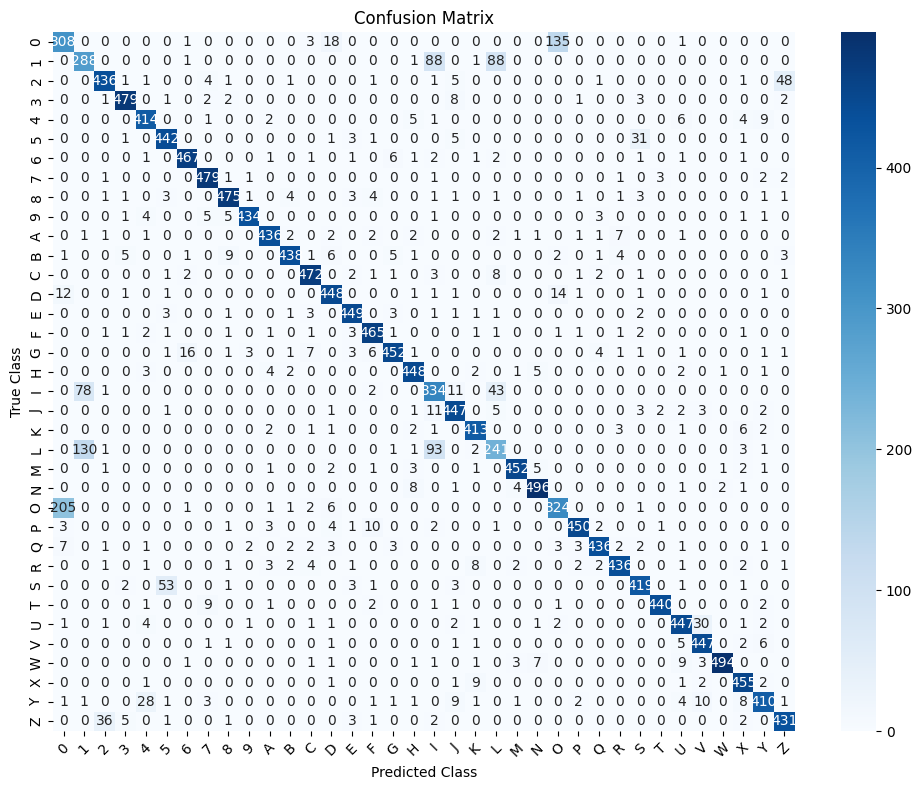

In [48]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
#                'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
class_names = classes

# Metrics using Sklearn
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ----------------------

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
# Save the trained model
torch.save(model.state_dict(), "emnist_cnn.pth")
print("Model saved as emnist_cnn.pth")

Model saved as emnist_cnn.pth


In [50]:
model = CNN()
model.load_state_dict(torch.load("emnist_cnn.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {accuracy:.4f}")


Accuracy: 0.8913
